In [3]:
import pandas as pd 
import numpy as np 
import os 
import scipy 
from scipy.stats import skew 
from scipy.stats import chi2
from scipy.stats import kurtosis 
import matplotlib.pyplot as plt

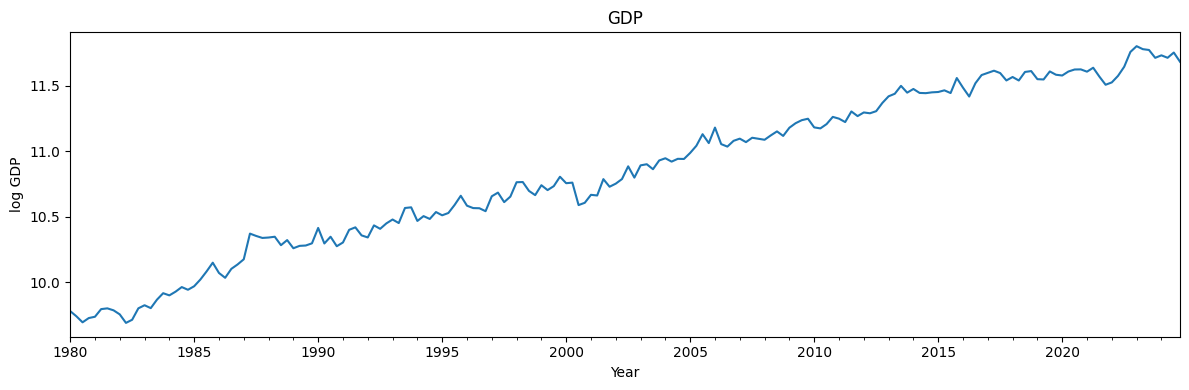

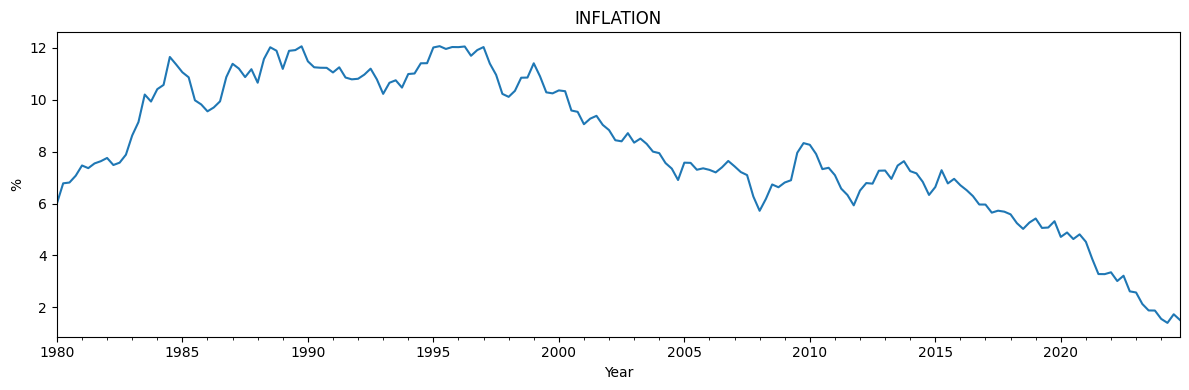

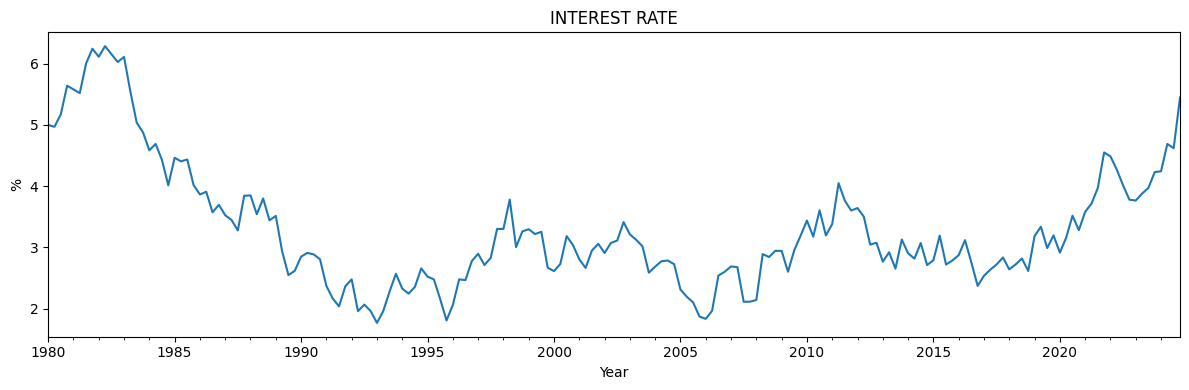

In [6]:
# Load data
data = pd.read_csv('./Multivariate-Econometrics/VU_MVE_assignment_timeseries_data.csv')
data['Period'] = pd.PeriodIndex(data['Period'], freq='Q').to_timestamp()
data = data.set_index('Period')
data.index.name = None

# 3.1.1 Plot time series
for col, ylabel in [("GDP", "log GDP"), ("INFLATION", "%"), ("INTEREST_RATE", "%")]:
    plt.figure(figsize=(12,4))
    data[col].plot()
    plt.title(f"{col.replace('_', ' ')}")
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [7]:
# Helper functions

def acf(x) -> np.ndarray:
    """Compute autocorrelation function"""
    x = np.asarray(x, dtype=float)
    n = len(x)
    x_center = x - np.nanmean(x)
    return (np.correlate(x_center, x_center, mode='full')[n-1:]) / (np.nanvar(x) * n)

def ljung_box_m(x, m=20):
    """Ljung-Box test for autocorrelation"""
    x = np.asarray(x, dtype=float)
    n = len(x)
    r = acf(x)
    k = int(min(m, len(r)-1, n-1))
    lags = np.arange(1, k+1)
    Q = n*(n+2) * np.sum((r[1:k+1]**2) / (n - lags))
    p = 1 - chi2.cdf(Q, k)
    return Q, p, k

def dickey_fuller_simple(x: np.ndarray) -> tuple[float, float]:
    """Simple DF: Δx_t = δ·x_{t-1} + u_t"""
    x = np.asarray(x, dtype=float)
    dx = np.diff(x)
    x_lag = x[:-1]
    delta_hat = np.linalg.lstsq(x_lag[:, None], dx, rcond=None)[0][0]
    u_hat = dx - delta_hat * x_lag
    s2_u = np.mean(u_hat**2)
    t_stat = delta_hat / np.sqrt(s2_u / np.sum(x_lag**2))
    return float(delta_hat), float(t_stat)

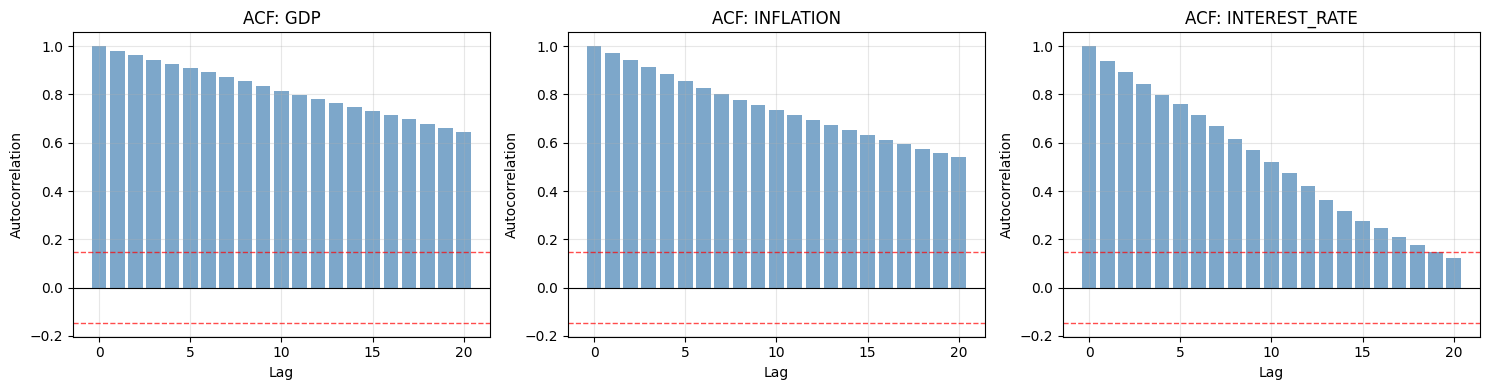

In [8]:
# Plot ACF correlograms for all three series
maxlag = 20

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, series) in enumerate([("GDP", data["GDP"]), 
                                       ("INFLATION", data["INFLATION"]), 
                                       ("INTEREST_RATE", data["INTEREST_RATE"])]):
    # Compute ACF
    rho = acf(series.values)
    k = min(maxlag, len(rho) - 1)
    lags = np.arange(0, k + 1)
    
    # Plot correlogram
    axes[idx].bar(lags, rho[:k+1], alpha=0.7, color='steelblue')
    axes[idx].axhline(0, color='black', linewidth=0.8)
    
    # Add confidence bands (approximate 95% CI: ±1.96/√n)
    n = len(series)
    conf_level = 1.96 / np.sqrt(n)
    axes[idx].axhline(conf_level, color='red', linestyle='--', linewidth=1, alpha=0.7)
    axes[idx].axhline(-conf_level, color='red', linestyle='--', linewidth=1, alpha=0.7)
    
    axes[idx].set_xlabel('Lag')
    axes[idx].set_ylabel('Autocorrelation')
    axes[idx].set_title(f'ACF: {name}')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# 3.1.2-3.1.3 ADF tests with lag selection

def calc_aic(n_obs, ssr, k_params):
    if ssr <= 0 or n_obs <= 0:
        return np.inf
    return 2 * k_params + n_obs * np.log(ssr / n_obs)

def calc_bic(n_obs, ssr, k_params):
    if ssr <= 0 or n_obs <= 0:
        return np.inf
    return k_params * np.log(n_obs) + n_obs * np.log(ssr / n_obs)

def _adf_design(y: np.ndarray, k: int, det: str):
    """Build design matrix for ADF regression. det: 'nc'/'c'/'ct'"""
    y = np.asarray(y, dtype=float)
    dy = np.diff(y)
    y_lag = y[:-1]

    if k > 0:
        dY_lags = np.column_stack([dy[j:-k+j] for j in range(k)])
    else:
        dY_lags = None

    if k > 0:
        y_dep = dy[k:]
        y_lag_aligned = y_lag[k:]
    else:
        y_dep = dy
        y_lag_aligned = y_lag

    T_eff = len(y_dep)
    cols = []
    if det in ('c','ct'):
        cols.append(np.ones(T_eff))
    if det == 'ct':
        cols.append(np.arange(1, T_eff+1, dtype=float))
    
    cols.append(y_lag_aligned)
    if k > 0:
        cols.append(dY_lags)

    X = np.column_stack([c if c.ndim == 1 else c for c in cols]) if len(cols) else None
    return y_dep, X

def _ols_fit(y_dep: np.ndarray, X: np.ndarray):
    XTX = X.T @ X
    XTy = X.T @ y_dep
    beta = np.linalg.lstsq(XTX, XTy, rcond=None)[0]
    resid = y_dep - X @ beta
    ssr = float(resid.T @ resid)
    n = len(y_dep)
    k_params = X.shape[1]
    s2 = ssr / n
    cov_beta = s2 * np.linalg.pinv(XTX)
    se = np.sqrt(np.diag(cov_beta))
    return beta, se, resid, ssr, n, k_params

def adf_manual(y: np.ndarray, k: int, det: str):
    """Run ADF test with k lags and specified deterministic terms"""
    y_dep, X = _adf_design(y, k=k, det=det)
    beta, se, resid, ssr, n, k_params = _ols_fit(y_dep, X)

    idx_delta = {'nc': 0, 'c': 1, 'ct': 2}[det]
    delta_hat = beta[idx_delta]
    t_stat = delta_hat / se[idx_delta]
    
    return {
        "det": det, "k": k,
        "delta_hat": float(delta_hat),
        "t_stat": float(t_stat),
        "residuals": resid,
        "ssr": ssr, "n_obs": n, "k_params": k_params
    }

def adf_select_ic(y: np.ndarray, det: str, kmax: int = 12, ic: str = "AIC"):
    rows = []
    for k in range(kmax+1):
        try:
            res = adf_manual(y, k=k, det=det)
            if ic.upper() == "AIC":
                ic_val = calc_aic(res["n_obs"], res["ssr"], res["k_params"])
            else:
                ic_val = calc_bic(res["n_obs"], res["ssr"], res["k_params"])
            rows.append({**res, "ic": ic.upper(), "ic_val": ic_val})
        except Exception as e:
            rows.append({"det": det, "k": k, "ic": ic.upper(), "error": str(e)})
    
    ok = [r for r in rows if "error" not in r]
    if not ok:
        return None
    best = min(ok, key=lambda r: r["ic_val"])
    return best, rows

# Critical values (5% significance)
CRIT_5 = {"nc": -1.95, "c": -2.86, "ct": -3.41}

def adf_decision_5pct(t_stat: float, det: str) -> bool:
    return (t_stat is not None) and (t_stat < CRIT_5[det])

# Run tests
series_dict = {
    "GDP": data["GDP"].values.astype(float),
    "INFLATION": data["INFLATION"].values.astype(float),
    "INTEREST_RATE": data["INTEREST_RATE"].values.astype(float),
}

results_rows = []

for name, y in series_dict.items():
    for det in ["nc","c","ct"]:
        for ic in ["AIC","BIC"]:
            best, all_rows = adf_select_ic(y, det=det, kmax=12, ic=ic)
            if best is None:
                results_rows.append({
                    "series": name, "det": det, "ic": ic,
                    "k_selected": np.nan, "t_stat": np.nan, "delta_hat": np.nan,
                    "n_obs": np.nan, "ssr": np.nan, "decision_5%": "error"
                })
                continue
            decision = "reject H0" if adf_decision_5pct(best["t_stat"], det) else "fail to reject"
            results_rows.append({
                "series": name,
                "det": best["det"],
                "ic": best["ic"],
                "k_selected": best["k"],
                "t_stat": round(best["t_stat"], 3),
                "delta_hat": round(best["delta_hat"], 6),
                "n_obs": best["n_obs"],
                "ssr": round(best["ssr"], 6),
                "IC value": round(best["ic_val"], 3),
                "decision_5%": decision
            })

adf_table = pd.DataFrame(results_rows)
display(adf_table.sort_values(["series","det","ic"]).reset_index(drop=True))

# 3.1.4 Determine order of integration
def pick_best_for(series: str, det_pref=("ct","c","nc")):
    sub = adf_table[(adf_table["series"]==series) & (adf_table["ic"]=="AIC")]
    for det in det_pref:
        m = sub[sub["det"]==det]
        if len(m):
            return m.loc[m["IC value"].idxmin()]
    return None

order_rows = []
for s in ["GDP","INFLATION","INTEREST_RATE"]:
    lvl = pick_best_for(s)
    d = np.diff(series_dict[s])
    
    diff_rows = []
    for det in ["nc","c","ct"]:
        for ic in ["AIC","BIC"]:
            best_d, _ = adf_select_ic(d, det=det, kmax=12, ic=ic)
            if best_d:
                diff_rows.append(best_d)
    
    best_diff = min(diff_rows, key=lambda r: r.get("ic_val", np.inf))
    diff_decision = "reject H0" if adf_decision_5pct(best_diff["t_stat"], best_diff["det"]) else "fail to reject"
    
    if lvl is not None and lvl["decision_5%"] == "reject H0":
        order = "I(0)"
    elif diff_decision == "reject H0":
        order = "I(1)"
    else:
        order = "I(2) or higher"
    
    order_rows.append({
        "Series": s,
        "Level decision": lvl["decision_5%"] if lvl is not None else "N/A",
        "1st diff decision": diff_decision,
        "Order": order
    })

order_table = pd.DataFrame(order_rows)
display(order_table)

,series,det,ic,k_selected,t_stat,delta_hat,n_obs,ssr,IC value,decision_5%
0,GDP,c,AIC,0,-1.088,-0.007379,179,0.526717,-1039.297,fail to reject
1,GDP,c,BIC,0,-1.088,-0.007379,179,0.526717,-1032.923,fail to reject
2,GDP,ct,AIC,0,-4.336,-0.202153,179,0.479077,-1054.267,reject H0
3,GDP,ct,BIC,0,-4.336,-0.202153,179,0.479077,-1044.705,reject H0
4,GDP,nc,AIC,0,2.545,0.000955,179,0.531170,-1039.791,fail to reject
5,GDP,nc,BIC,0,2.545,0.000955,179,0.531170,-1036.603,fail to reject
6,INFLATION,c,AIC,1,0.391,0.004168,178,25.243248,-341.674,fail to reject
7,INFLATION,c,BIC,0,0.495,0.005276,179,26.175624,-333.763,fail to reject
8,INFLATION,ct,AIC,0,-2.998,-0.047662,179,23.702330,-355.904,fail to reject
9,INFLATION,ct,BIC,0,-2.998,-0.047662,179,23.702330,-346.342,fail to reject


,Series,Level decision,1st diff decision,Order
0,GDP,reject H0,reject H0,I(0)
1,INFLATION,fail to reject,reject H0,I(1)
2,INTEREST_RATE,fail to reject,reject H0,I(1)


=== GDP ~ INFLATION (levels) — OLS results ===
alpha (const)  = 12.128018  SE=0.099102  t=122.38
alpha1 (slope) = -0.157706  SE=0.011512  t=-13.70
R^2            = 0.5132
n=180, k=2, SSR=31.4586


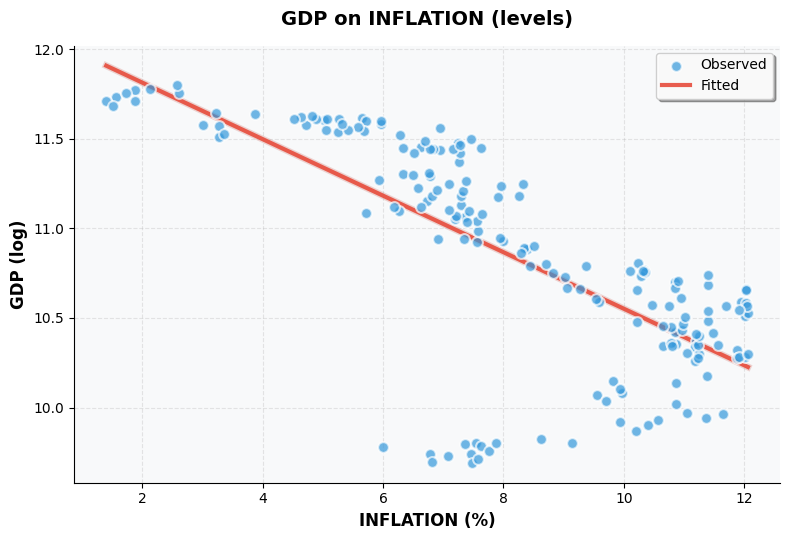

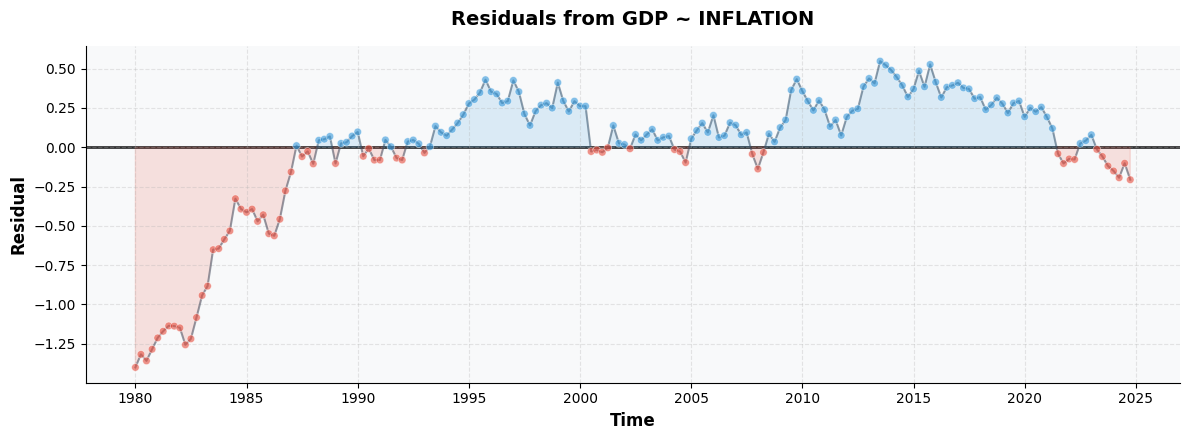

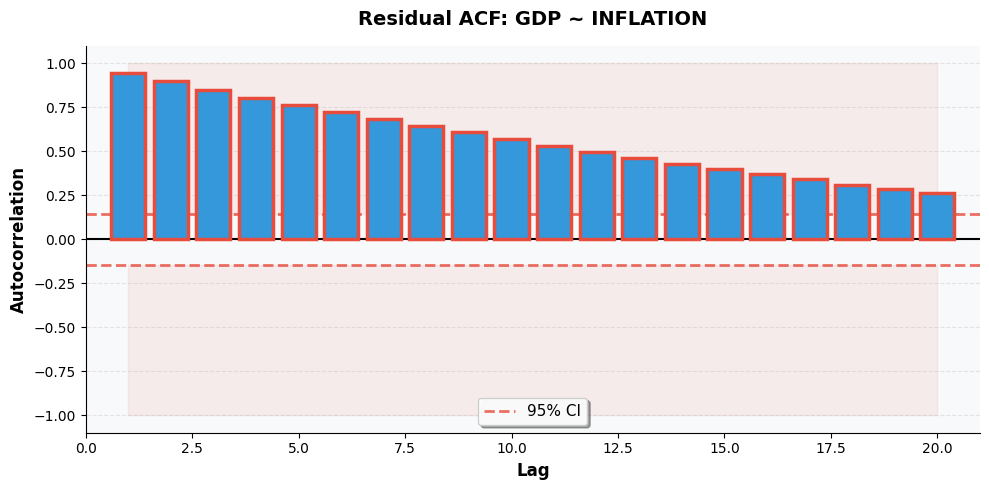

Ljung-Box Q(10) = 1078.59,  p-value = 0.000
=== Simple DF on residuals ===
delta_hat = -0.050475,  t-stat = -3.495,  5% crit ≈ -1.95
Decision: REJECT H0 (stationary)


In [10]:
# 3.2 Spurious Regression (GDP on INFLATION, levels)
y = data['GDP'].values.astype(float)
x = data['INFLATION'].values.astype(float)

X = np.column_stack((np.ones(len(x)), x))
beta = np.linalg.lstsq(X, y, rcond=None)[0]
y_hat = X @ beta
resid = y - y_hat

n = len(y)
k = X.shape[1]
ssr = float(np.sum(resid**2))
s2 = ssr / (n - k)
cov_beta = s2 * np.linalg.inv(X.T @ X)
se_beta = np.sqrt(np.diag(cov_beta))
t_beta = beta / se_beta
r2 = 1 - ssr / np.sum((y - y.mean())**2)

print("=== GDP ~ INFLATION (levels) — OLS results ===")
print(f"alpha (const)  = {beta[0]:.6f}  SE={se_beta[0]:.6f}  t={t_beta[0]:.2f}")
print(f"alpha1 (slope) = {beta[1]:.6f}  SE={se_beta[1]:.6f}  t={t_beta[1]:.2f}")
print(f"R^2            = {r2:.4f}")
print(f"n={n}, k={k}, SSR={ssr:.4f}")

# Scatter plot with fitted line
fig, ax = plt.subplots(figsize=(8, 5.5), facecolor='white')
ax.set_facecolor('#f8f9fa')
ax.scatter(x, y, alpha=0.7, s=60, c='#3498db', 
           edgecolors='white', linewidths=1.5, zorder=3, label='Observed')

xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
ax.plot(xs, beta[0] + beta[1]*xs, color='#e74c3c', linewidth=3, 
        alpha=0.9, zorder=2, label='Fitted')
ax.plot(xs, beta[0] + beta[1]*xs, color='#c0392b', linewidth=5, 
        alpha=0.2, zorder=1)

ax.set_xlabel("INFLATION (%)", fontsize=12, fontweight='bold')
ax.set_ylabel("GDP (log)", fontsize=12, fontweight='bold')
ax.set_title("GDP on INFLATION (levels)", fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=10, framealpha=0.95, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Residual time plot
fig, ax = plt.subplots(figsize=(12, 4.5), facecolor='white')
ax.set_facecolor('#f8f9fa')

colors = ['#e74c3c' if r < 0 else '#3498db' for r in resid]
ax.scatter(data.index, resid, c=colors, alpha=0.6, s=30, edgecolors='white', 
           linewidths=0.5, zorder=3)
ax.plot(data.index, resid, color='#34495e', linewidth=1.5, alpha=0.5, zorder=2)

ax.axhline(0, color='black', linewidth=2, linestyle='-', alpha=0.8, zorder=1)
ax.fill_between(data.index, 0, resid, where=(resid > 0), 
                alpha=0.15, color='#3498db', interpolate=True)
ax.fill_between(data.index, 0, resid, where=(resid < 0), 
                alpha=0.15, color='#e74c3c', interpolate=True)

ax.set_title("Residuals from GDP ~ INFLATION", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Residual", fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Residual ACF
rho_full = acf(resid)
kbar = int(min(maxlag, len(rho_full)-1))
lags = np.arange(1, kbar+1)
heights = rho_full[1:kbar+1]

fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')
ax.set_facecolor('#f8f9fa')

bars = ax.bar(lags, heights, alpha=0.85, color='#3498db', edgecolor='#2c3e50', 
              linewidth=1.2, zorder=3)

n_resid = len(resid)
conf_level = 1.96 / np.sqrt(n_resid)
for i, (lag, height) in enumerate(zip(lags, heights)):
    if abs(height) > conf_level:
        bars[i].set_edgecolor('#e74c3c')
        bars[i].set_linewidth(2.5)
        bars[i].set_alpha(1.0)

ax.axhline(0, color='black', linewidth=1.5, zorder=2)
ax.axhline(conf_level, color='#e74c3c', linestyle='--', linewidth=2, 
           alpha=0.8, label='95% CI', zorder=1)
ax.axhline(-conf_level, color='#e74c3c', linestyle='--', linewidth=2, 
           alpha=0.8, zorder=1)
ax.fill_between(lags, conf_level, 1, alpha=0.08, color='#e74c3c')
ax.fill_between(lags, -conf_level, -1, alpha=0.08, color='#e74c3c')

ax.set_title("Residual ACF: GDP ~ INFLATION", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Lag", fontsize=12, fontweight='bold')
ax.set_ylabel("Autocorrelation", fontsize=12, fontweight='bold')
ax.legend(fontsize=11, framealpha=0.95, shadow=True)
ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, kbar + 1)
plt.tight_layout()
plt.show()

# Ljung-Box test
Q10, p10, k_used = ljung_box_m(resid, m=10)
print(f"Ljung-Box Q({k_used}) = {Q10:.2f},  p-value = {p10:.3f}")

# DF test on residuals
delta_hat_res, t_stat_res = dickey_fuller_simple(resid)
crit_no_const_5 = -1.95
decision = "REJECT H0 (stationary)" if t_stat_res < crit_no_const_5 else "FAIL TO REJECT (unit root)"
print("=== Simple DF on residuals ===")
print(f"delta_hat = {delta_hat_res:.6f},  t-stat = {t_stat_res:.3f},  5% crit ≈ {crit_no_const_5}")
print(f"Decision: {decision}")

=== EG Step 1: Cointegrating regression (GDP on INTEREST_RATE, levels) ===
beta0 = 11.563050  (SE=0.144049)
beta1 = -0.219353  (SE=0.041821)
R^2   = 0.1339,  n=180, k=2,  SSR=55.9764


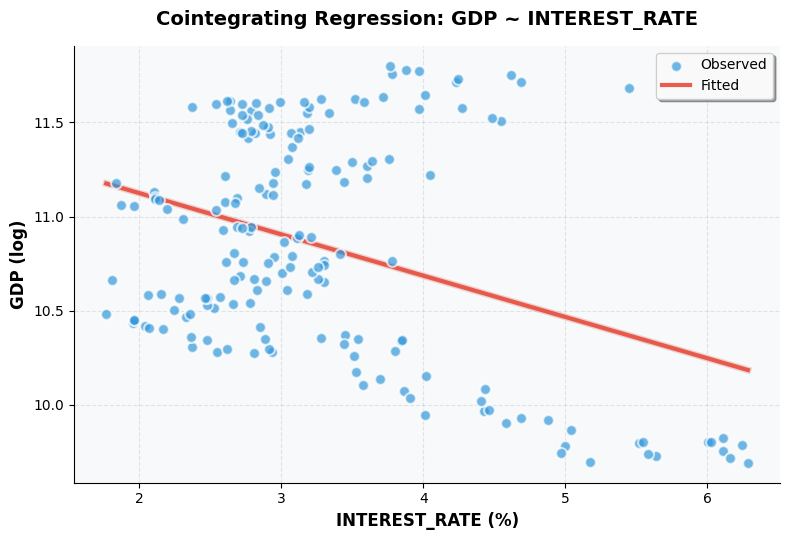


=== EG Step 2: DF test on residuals û_t ===
DF t-stat = 0.353  |  5% EG crit ≈ -3.34
Decision: FAIL TO REJECT — no cointegration

[No ECM estimated — cointegration not found]


In [11]:
# 3.3 Cointegration Analysis (Engle-Granger + ECM)

def ols_fit(y, X):
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    y_hat = X @ beta
    resid = y - y_hat
    n = len(y)
    k = X.shape[1]
    ssr = float(resid.T @ resid)
    s2 = ssr / (n - k)
    covb = s2 * np.linalg.inv(X.T @ X)
    se_beta = np.sqrt(np.diag(covb))
    r2 = 1 - ssr / np.sum((y - np.mean(y))**2)
    return beta, y_hat, resid, se_beta, r2, ssr, s2, n, k

def dickey_fuller_simple(x: np.ndarray) -> tuple[float, float]:
    """Simple DF: Δx_t = δ·x_{t-1} + u_t"""
    x = np.asarray(x, dtype=float)
    dx = np.diff(x)
    x_lag = x[:-1]
    delta_hat = np.linalg.lstsq(x_lag[:, None], dx, rcond=None)[0][0]
    u_hat = dx - delta_hat * x_lag
    s2_u = np.mean(u_hat**2)
    t_stat = delta_hat / np.sqrt(s2_u / np.sum(x_lag**2))
    return float(delta_hat), float(t_stat)

# Data
Y = data['GDP'].values.astype(float)
IR = data['INTEREST_RATE'].values.astype(float)

# Step 1: Cointegrating regression
X_c = np.column_stack((np.ones(len(IR)), IR))
beta_c, yhat_c, uhat, se_c, r2_c, ssr_c, s2_c, n_c, k_c = ols_fit(Y, X_c)

print("=== EG Step 1: Cointegrating regression (GDP on INTEREST_RATE, levels) ===")
print(f"beta0 = {beta_c[0]:.6f}  (SE={se_c[0]:.6f})")
print(f"beta1 = {beta_c[1]:.6f}  (SE={se_c[1]:.6f})")
print(f"R^2   = {r2_c:.4f},  n={n_c}, k={k_c},  SSR={ssr_c:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(8, 5.5), facecolor='white')
ax.set_facecolor('#f8f9fa')
ax.scatter(IR, Y, alpha=0.7, s=60, c='#3498db', 
           edgecolors='white', linewidths=1.5, zorder=3, label='Observed')

xs = np.linspace(np.nanmin(IR), np.nanmax(IR), 200)
ax.plot(xs, beta_c[0] + beta_c[1]*xs, color='#e74c3c', linewidth=3, 
        alpha=0.9, zorder=2, label='Fitted')
ax.plot(xs, beta_c[0] + beta_c[1]*xs, color='#c0392b', linewidth=5, 
        alpha=0.2, zorder=1)

ax.set_xlabel("INTEREST_RATE (%)", fontsize=12, fontweight='bold')
ax.set_ylabel("GDP (log)", fontsize=12, fontweight='bold')
ax.set_title("Cointegrating Regression: GDP ~ INTEREST_RATE", fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=10, framealpha=0.95, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Step 2: DF test on residuals
delta_u, tstat_u = dickey_fuller_simple(uhat)
CRIT_EG_5_const = -3.34
reject_cointegration_null = tstat_u < CRIT_EG_5_const

print("\n=== EG Step 2: DF test on residuals û_t ===")
print(f"DF t-stat = {tstat_u:.3f}  |  5% EG crit ≈ {CRIT_EG_5_const}")
print("Decision:", "REJECT — cointegration detected"
      if reject_cointegration_null else "FAIL TO REJECT — no cointegration")

# Error Correction Model
if reject_cointegration_null:
    dGDP = np.diff(Y)
    dIR  = np.diff(IR)
    ECM_lag1 = uhat[:-1]
    dGDP_lag1 = np.concatenate([[np.nan], dGDP[:-1]])
    
    df_ecm = pd.DataFrame({
        "dGDP": dGDP,
        "ECM_lag1": ECM_lag1,
        "dGDP_lag1": dGDP_lag1[1:],
        "dIR": dIR
    }).dropna()
    
    y_ecm = df_ecm["dGDP"].values
    X_ecm = np.column_stack((
        np.ones(len(df_ecm)),
        df_ecm["ECM_lag1"].values,
        df_ecm["dGDP_lag1"].values,
        df_ecm["dIR"].values
    ))

    beta_e, yhat_e, resid_e, se_e, r2_e, ssr_e, s2_e, n_e, k_e = ols_fit(y_ecm, X_ecm)

    print("\n=== ECM (ΔGDP on [const, ECM_{t-1}, ΔGDP_{t-1}, ΔIR]) ===")
    names = ["alpha0","alpha1(ECM_{t-1})","gamma1(ΔGDP_{t-1})","delta1(ΔIR)"]
    for nm, b, se in zip(names, beta_e, se_e):
        print(f"{nm:>22s} = {b:.6f}   (SE={se:.6f})")
    print(f"R^2 = {r2_e:.4f},  n={n_e}, k={k_e},  SSR={ssr_e:.4f}")

    if beta_e[1] < 0:
        print("Note: alpha1 < 0 → error correction active")
    else:
        print("Note: alpha1 ≥ 0 → weak/no error correction")
    
    plt.figure(figsize=(10,3.6))
    plt.plot(resid_e)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title("ECM residuals")
    plt.tight_layout()
    plt.show()
else:
    print("\n[No ECM estimated — cointegration not found]")

COINTEGRATION TESTING: ALL PAIRS

Testing: GDP ~ INFLATION

Step 1: GDP = β0 + β1·INFLATION + u
  β0 = 12.128018  (SE=0.099102)
  β1 = -0.157706  (SE=0.011512)
  R² = 0.5132

Step 2: DF test on residuals
  t-stat = -3.495  |  crit = -3.34
  ✓ COINTEGRATED

Testing: GDP ~ INTEREST_RATE

Step 1: GDP = β0 + β1·INTEREST_RATE + u
  β0 = 11.563050  (SE=0.144049)
  β1 = -0.219353  (SE=0.041821)
  R² = 0.1339

Step 2: DF test on residuals
  t-stat = 0.353  |  crit = -3.34
  ✗ NOT cointegrated

Testing: INFLATION ~ INTEREST_RATE

Step 1: INFLATION = β0 + β1·INTEREST_RATE + u
  β0 = 10.408504  (SE=0.680849)
  β1 = -0.679983  (SE=0.197667)
  R² = 0.0623

Step 2: DF test on residuals
  t-stat = -0.176  |  crit = -3.34
  ✗ NOT cointegrated

SUMMARY



,Pair,β0,β1,R²,t-stat,Cointegrated?
0,GDP ~ INFLATION,12.1280,-0.1577,0.5132,-3.495,Yes
1,GDP ~ INTEREST_RATE,11.5631,-0.2194,0.1339,0.353,No
2,INFLATION ~ INTEREST_RATE,10.4085,-0.6800,0.0623,-0.176,No



Critical value: -3.34 (5% significance)


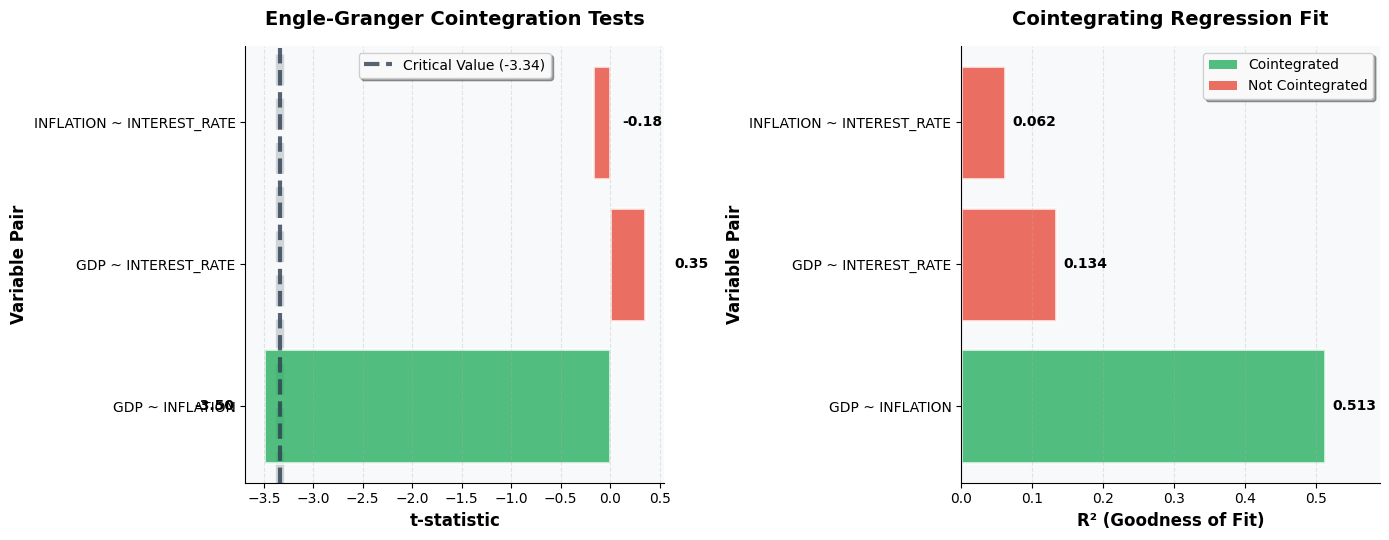

In [12]:
# Pairwise cointegration tests

print("="*70)
print("COINTEGRATION TESTING: ALL PAIRS")
print("="*70)

GDP = data['GDP'].values.astype(float)
INFL = data['INFLATION'].values.astype(float)
IR = data['INTEREST_RATE'].values.astype(float)

CRIT_EG = -3.34
cointegration_results = []

pairs = [
    ("GDP", "INFLATION", GDP, INFL),
    ("GDP", "INTEREST_RATE", GDP, IR),
    ("INFLATION", "INTEREST_RATE", INFL, IR)
]

for var1_name, var2_name, var1, var2 in pairs:
    print(f"\n{'='*70}")
    print(f"Testing: {var1_name} ~ {var2_name}")
    print(f"{'='*70}")
    
    X_temp = np.column_stack((np.ones(len(var2)), var2))
    beta_temp, yhat_temp, uhat_temp, se_temp, r2_temp, _, _, n_temp, k_temp = ols_fit(var1, X_temp)
    
    print(f"\nStep 1: {var1_name} = β0 + β1·{var2_name} + u")
    print(f"  β0 = {beta_temp[0]:.6f}  (SE={se_temp[0]:.6f})")
    print(f"  β1 = {beta_temp[1]:.6f}  (SE={se_temp[1]:.6f})")
    print(f"  R² = {r2_temp:.4f}")
    
    delta_temp, tstat_temp = dickey_fuller_simple(uhat_temp)
    
    print(f"\nStep 2: DF test on residuals")
    print(f"  t-stat = {tstat_temp:.3f}  |  crit = {CRIT_EG}")
    
    is_cointegrated = tstat_temp < CRIT_EG
    decision_str = "✓ COINTEGRATED" if is_cointegrated else "✗ NOT cointegrated"
    print(f"  {decision_str}")
    
    cointegration_results.append({
        "Pair": f"{var1_name} ~ {var2_name}",
        "β0": f"{beta_temp[0]:.4f}",
        "β1": f"{beta_temp[1]:.4f}",
        "R²": f"{r2_temp:.4f}",
        "t-stat": f"{tstat_temp:.3f}",
        "Cointegrated?": "Yes" if is_cointegrated else "No"
    })

print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}\n")

results_df = pd.DataFrame(cointegration_results)
display(results_df)
print(f"\nCritical value: {CRIT_EG} (5% significance)")

# Visualization
pair_labels = [r["Pair"] for r in cointegration_results]
t_stats = [float(r["t-stat"]) for r in cointegration_results]
r2_values = [float(r["R²"]) for r in cointegration_results]
is_coint = [r["Cointegrated?"] == "Yes" for r in cointegration_results]
colors = ['#27ae60' if coint else '#e74c3c' for coint in is_coint]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5.5), facecolor='white')

# Plot 1: t-statistics
ax1.set_facecolor('#f8f9fa')
bars = ax1.barh(pair_labels, t_stats, color=colors, alpha=0.8, edgecolor='white', linewidth=2)

ax1.axvline(CRIT_EG, color='#2c3e50', linewidth=3, linestyle='--', 
            label=f'Critical Value ({CRIT_EG})', alpha=0.8, zorder=1)
ax1.axvline(CRIT_EG, color='#34495e', linewidth=6, linestyle='--', alpha=0.2, zorder=0)

for bar, val in zip(bars, t_stats):
    offset = -0.3 if val < CRIT_EG else 0.3
    ha = 'right' if val < CRIT_EG else 'left'
    ax1.text(val + offset, bar.get_y() + bar.get_height()/2, 
             f'{val:.2f}', va='center', ha=ha, fontweight='bold', fontsize=10)

ax1.set_xlabel('t-statistic', fontsize=12, fontweight='bold')
ax1.set_ylabel('Variable Pair', fontsize=12, fontweight='bold')
ax1.set_title('Engle-Granger Cointegration Tests', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10, framealpha=0.95, shadow=True)
ax1.grid(True, alpha=0.3, axis='x', linestyle='--', linewidth=0.8)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: R² values
ax2.set_facecolor('#f8f9fa')
bars2 = ax2.barh(pair_labels, r2_values, color=colors, alpha=0.8, edgecolor='white', linewidth=2)

for bar, val in zip(bars2, r2_values):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', va='center', ha='left', fontweight='bold', fontsize=10)

ax2.set_xlabel('R² (Goodness of Fit)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Variable Pair', fontsize=12, fontweight='bold')
ax2.set_title('Cointegrating Regression Fit', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlim(0, max(r2_values) * 1.15)
ax2.grid(True, alpha=0.3, axis='x', linestyle='--', linewidth=0.8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', alpha=0.8, label='Cointegrated'),
    Patch(facecolor='#e74c3c', alpha=0.8, label='Not Cointegrated')
]
ax2.legend(handles=legend_elements, fontsize=10, framealpha=0.95, shadow=True)

plt.tight_layout()
plt.show()